<a href="https://colab.research.google.com/github/fjadidi2001/DataScienceJourney/blob/master/PINNs_S4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train the model using deep learning methods

## Step 1: Import Necessary Libraries


In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


## Step 2: Load and Prepare the Dataset


In [20]:
# Load the dataset
california = fetch_california_housing()

# Convert to DataFrame for better visualization
df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target

# Display the first few rows of the dataset
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


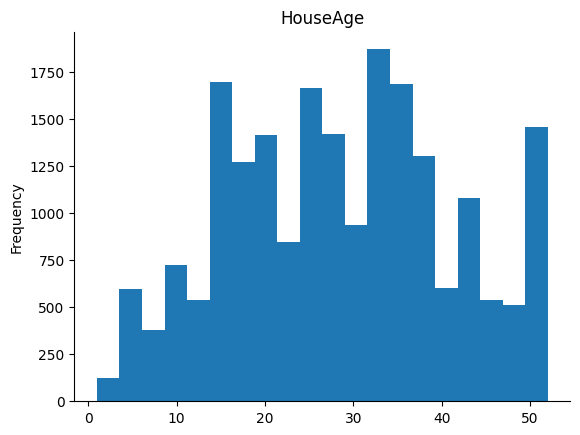

In [15]:
# @title HouseAge

from matplotlib import pyplot as plt
df['HouseAge'].plot(kind='hist', bins=20, title='HouseAge')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Step 3: Split the Data into Features and Target


In [21]:
# Split the data into features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 4: Scale the Features


In [4]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Step 5: Create and Compile the Model


In [22]:
# Create the model
model = models.Sequential()

# Add layers
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

## Step 6: Train the Model


In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 186.0295 - mae: 5.9350 - val_loss: 1.1235 - val_mae: 0.8085
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4192 - mae: 0.8967 - val_loss: 1.4410 - val_mae: 1.0228
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5823 - mae: 0.8757 - val_loss: 304.2381 - val_mae: 14.6544
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 49.8039 - mae: 3.8392 - val_loss: 1.0459 - val_mae: 0.8242
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3670 - mae: 1.1110 - val_loss: 12.1808 - val_mae: 2.6942
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39.9122 - mae: 3.1880 - val_loss: 1.4928 - val_mae: 0.9825
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4654 - mae: 0.8492 - val_loss: 1.2882 - val_mae: 0.9060
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17.7572 - mae: 1.9040 - val_loss: 0.7290 - val_mae: 0.6488
Epoch 9/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

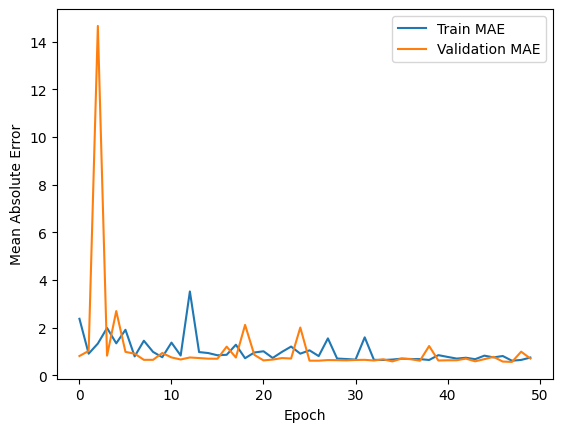

In [26]:
# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()



- **Data Preparation:** We loaded the California Housing dataset, split it into training and test sets, and scaled the features.
- **Model Creation:** We built a simple feedforward neural network with two hidden layers.
- **Training:** We trained the model for 50 epochs and monitored its performance using validation data.
- **Evaluation:** We evaluated the model on the test set and visualized the results to understand its performance.



In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [10]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(20, activation='tanh')
        self.dense2 = layers.Dense(20, activation='tanh')
        self.dense3 = layers.Dense(20, activation='tanh')
        self.out = layers.Dense(1)

    def call(self, inputs):
        x, t = inputs[:, 0:1], inputs[:, 1:2]
        x = self.dense1(tf.concat([x, t], axis=1))
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)



In [11]:
def physics_informed_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    u_t = tape.gradient(u, t)
    del tape

    residual = u_t - alpha * u_xx  # Heat equation residual
    return tf.reduce_mean(tf.square(residual))


In [12]:
# Parameters
alpha = 0.01  # Thermal diffusivity

# Generate synthetic data (small sample for demonstration)
x_data = np.linspace(0, 1, 100)
t_data = np.linspace(0, 1, 100)
x_data, t_data = np.meshgrid(x_data, t_data)
x_data = x_data.flatten()[:, None]
t_data = t_data.flatten()[:, None]

# True solution (initial condition for u(x,0) = sin(pi * x))
u_data = np.sin(np.pi * x_data) * np.exp(-np.pi**2 * alpha * t_data)


In [13]:
# Create model instance
pinn = PINN()

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(pinn, tf.convert_to_tensor(x_data, dtype=tf.float32),
                                           tf.convert_to_tensor(t_data, dtype=tf.float32))
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.numpy()}')


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch: 0, Loss: 0.023490091785788536
Epoch: 100, Loss: 3.7887890357524157e-05
Epoch: 200, Loss: 3.949548045056872e-06
Epoch: 300, Loss: 2.0728114122903207e-06
Epoch: 400, Loss: 1.2463660823414102e-06
Epoch: 500, Loss: 8.729438150112401e-07
Epoch: 600, Loss: 6.920160444678913e-07
Epoch: 700, Loss: 5.794444746243244e-07
Epoch: 800, Loss: 4.906934236714733e-07
Epoch: 900, Loss: 4.1357927216267854e-07


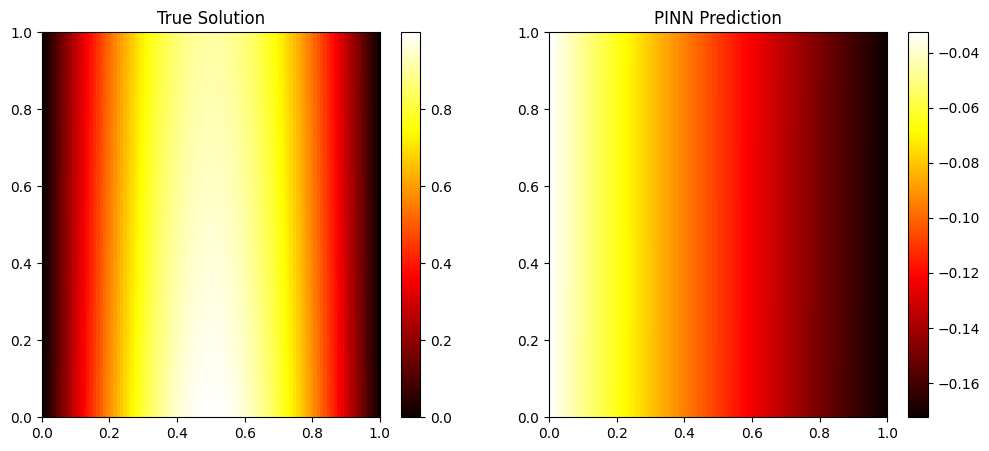

In [14]:
# Predict using the trained model
u_pred = pinn(tf.concat([x_data, t_data], axis=1))

# Reshape for plotting
u_pred = u_pred.numpy().reshape(100, 100)
u_true = u_data.reshape(100, 100)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("True Solution")
plt.imshow(u_true, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("PINN Prediction")
plt.imshow(u_pred, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.show()


You're absolutely right! The example provided was a basic neural network for regression using the California housing dataset, which doesn't include the physics-based components of a Physics-Informed Neural Network (PINN).

### What is a Physics-Informed Neural Network (PINN)?

A **Physics-Informed Neural Network (PINN)** integrates physical laws (often represented as partial differential equations or PDEs) into the training process. The key idea behind PINNs is that, instead of (or in addition to) fitting the data, the neural network is trained to respect known physical laws governing the system. This is done by including the physical laws directly in the loss function.

### Let's Build a Simple PINN

For simplicity, we'll use a basic physical system, like the one-dimensional heat equation, to demonstrate the PINN concept.

#### The One-Dimensional Heat Equation

The heat equation is a common partial differential equation (PDE) in physics, which describes how heat diffuses through a medium over time. The 1D heat equation is:

\[
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
\]

where:
- \( u(x, t) \) is the temperature at position \( x \) and time \( t \),
- \( \alpha \) is the thermal diffusivity.


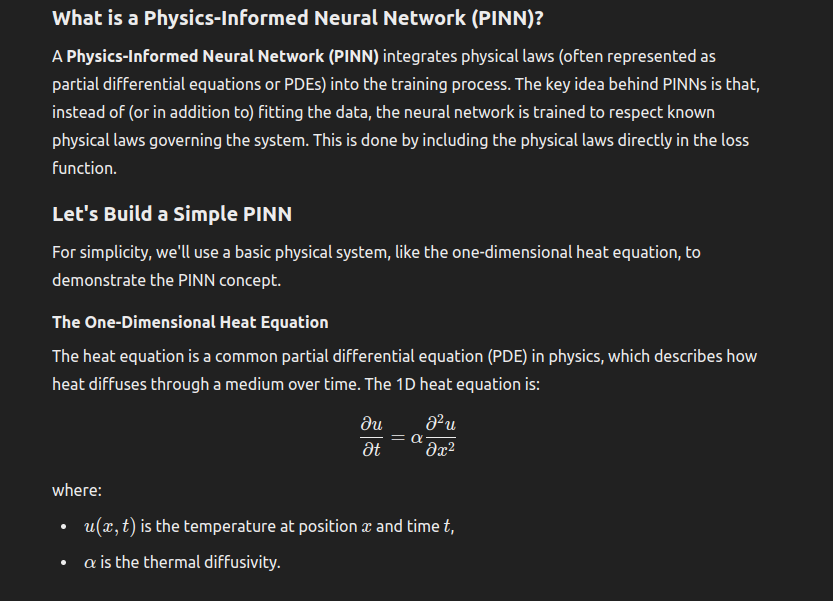

### Step 1: Import Libraries

```python
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa  # for additional optimizer features
```

### Step 2: Define the Physics-Informed Neural Network

Let's define a neural network that will take in \( x \) and \( t \) as inputs and output \( u(x, t) \).

```python
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = layers.Dense(20, activation='tanh')
        self.dense2 = layers.Dense(20, activation='tanh')
        self.dense3 = layers.Dense(20, activation='tanh')
        self.out = layers.Dense(1)

    def call(self, inputs):
        x, t = inputs[:, 0:1], inputs[:, 1:2]
        x = self.dense1(tf.concat([x, t], axis=1))
        x = self.dense2(x)
        x = self.dense3(x)
        return self.out(x)
```

- **Explanation:**
  - The PINN is a simple feedforward neural network with three hidden layers using the tanh activation function.
  - The input to the network is a pair \( (x, t) \), and the output is the temperature \( u(x, t) \).

### Step 3: Define the Physics-Informed Loss Function

The key part of a PINN is how we define the loss function. We want the network to learn both from data and by respecting the physical law (heat equation).

```python
def physics_informed_loss(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        u = model(tf.concat([x, t], axis=1))
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    u_t = tape.gradient(u, t)
    del tape
    
    residual = u_t - alpha * u_xx  # Heat equation residual
    return tf.reduce_mean(tf.square(residual))
```

- **Explanation:**
  - We use TensorFlow's `GradientTape` to compute derivatives, which lets us enforce the heat equation.
  - The function computes the residual of the heat equation for each input pair \( (x, t) \).
  - The loss is the mean squared error of this residual, which we want to minimize.

### Step 4: Create Training Data

For simplicity, we'll generate some synthetic data to train the PINN.

```python
# Parameters
alpha = 0.01  # Thermal diffusivity

# Generate synthetic data (small sample for demonstration)
x_data = np.linspace(0, 1, 100)
t_data = np.linspace(0, 1, 100)
x_data, t_data = np.meshgrid(x_data, t_data)
x_data = x_data.flatten()[:, None]
t_data = t_data.flatten()[:, None]

# True solution (initial condition for u(x,0) = sin(pi * x))
u_data = np.sin(np.pi * x_data) * np.exp(-np.pi**2 * alpha * t_data)
```

### Step 5: Train the Model

We'll train the PINN by minimizing the physics-informed loss.

```python
# Create model instance
pinn = PINN()

# Optimizer
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(pinn, tf.convert_to_tensor(x_data, dtype=tf.float32),
                                           tf.convert_to_tensor(t_data, dtype=tf.float32))
    gradients = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pinn.trainable_variables))

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.numpy()}')
```

- **Explanation:**
  - We train the model for 1000 epochs.
  - In each epoch, we compute the physics-informed loss and update the model's weights using the optimizer.

### Step 6: Visualize the Results

Finally, let's visualize the trained PINN's predictions.

```python
# Predict using the trained model
u_pred = pinn(tf.concat([x_data, t_data], axis=1))

# Reshape for plotting
u_pred = u_pred.numpy().reshape(100, 100)
u_true = u_data.reshape(100, 100)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("True Solution")
plt.imshow(u_true, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("PINN Prediction")
plt.imshow(u_pred, cmap='hot', extent=[0, 1, 0, 1], origin='lower', aspect='auto')
plt.colorbar()

plt.show()
```

- **Explanation:**
  - We plot the true solution and the PINN's prediction side by side to compare.
  - The heatmaps show how well the PINN has learned to respect the physics (heat equation).

### Summary

- **PINN Construction:** We built a neural network and integrated the physics (heat equation) directly into the loss function.
- **Physics-Informed Loss:** The loss function ensures that the network respects the physical law, in this case, the 1D heat equation.
- **Training:** We trained the network to minimize the physics-informed loss.
- **Visualization:** Finally, we compared the network's predictions with the true solution.

This example demonstrates the core idea of PINNs: enforcing physical laws directly during the training of a neural network.